# Crime Analysis Notebook
### This notebook contains the steps used to set up the .aprx file for the analysis.
### This notebook is divided by the following sections:
- Creating Regions
- Join Tables
- Analysis

In [1]:
import arcpy
arcpy.env.overwriteOutput = True
arcpy.env.workspace = r"C:\Users\viver\OneDrive\Desktop\crime_analysis\crime_analysis.gdb"

## Creating Regions

In [6]:
regions = {'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'New Jersey', 'Pennsylvania'],
           'Midwest': ['Ohio', 'Michigan', 'Indiana', 'Illinois', 'Wisconsin', 'Minnesota', 'Iowa', 'Missouri', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas'],
           'South': ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Alabama', 'Mississippi', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
           'West': ['Montana', 'Idaho', 'Wyoming', 'Colorado', 'New Mexico', 'Arizona', 'Utah', 'Nevada', 'Washington', 'Oregon', 'California', 'Alaska', 'Hawaii']
}

In [ ]:
# Test code to find region for a state
target = "Maine"
for key, values in regions.items():
    if target in values:
        print(f"{key}")
        break

Northeast


In [4]:
# Add "Region" field to USA_States feature class
fc = "USA_States"
arcpy.management.AddField(fc, "Region", "TEXT")
fields = arcpy.ListFields(fc)
for field in fields:
    print(f"{field.name} - {field.type}")

OBJECTID - OID
Shape - Geometry
STATE_ABBR - String
STATE_FIPS - String
STATE_NAME - String
POPULATION - Integer
POP_SQMI - Double
SQMI - Double
Shape_Length - Double
Shape_Area - Double
Region - String


In [22]:
# Update "Region" field based on "STATE_NAME" field
fields = ["Region", "STATE_NAME"]
with arcpy.da.UpdateCursor(fc, fields) as cursor:
    for row in cursor:
        state_name = row[fields.index("STATE_NAME")]
        for region, states in regions.items():
            if state_name in states:
                row[fields.index("Region")] = region
                cursor.updateRow(row)
                break

## Join Tables

In [ ]:
# Join political party data to states feature class
POLITICAL_PARTY_TABLE = r"C:\Users\viver\Documents\git\gis-portfolio\projects\crime-analysis\data\final\state_majority_party.csv"
states_political_joined_table = arcpy.management.AddJoin(fc, "STATE_NAME", POLITICAL_PARTY_TABLE, "State")
arcpy.management.CopyFeatures(states_political_joined_table, "USA_States_Political_Join")

<Result 'C:\\Users\\viver\\OneDrive\\Desktop\\crime_analysis\\crime_analysis.gdb\\USA_States_Joined'>

In [ ]:
# Join crime data to previously joined feature class
CRIME_DATA_TABLE = r"C:\Users\viver\Documents\git\gis-portfolio\projects\crime-analysis\data\raw\Violent crime and solved crime by state, 2024 - Sheet1.csv"
in_feature = "USA_States_Political_Join"
states_crime_joined_table = arcpy.management.AddJoin(in_feature, "USA_States_STATE_NAME", CRIME_DATA_TABLE, "State")
arcpy.management.CopyFeatures(states_crime_joined_table, "USA_States_Crime_Join")

## Analysis and Figure Creation

In [ ]:
# Run summary statistics to calculate mean and median violent crime by political party
in_table = "USA_States_Crime_Join"
out_table = "Crime_Summary_Statistics"
statistics_fields = [["Violent_crime_and_solved_crime_by_state__2024___Sheet1_csv_Viole", "MEAN"],
                      ["Violent_crime_and_solved_crime_by_state__2024___Sheet1_csv_Viole", "MEDIAN"]]
case_field = "USA_States_Political_Join_state_majority_party_csv_Majority_Part"
arcpy.analysis.Statistics(in_table, out_table, statistics_fields, case_field)

<Result 'C:\\Users\\viver\\OneDrive\\Desktop\\crime_analysis\\crime_analysis.gdb\\Crime_Summary_Statistics'>

In [5]:
# Run summary statistics to calculate mean and median violent crime by region
in_table = "USA_States_Crime_Join"
out_table = "USA_States_Region_Statistics"
statistics_fields = [["Violent_crime_and_solved_crime_by_state__2024___Sheet1_csv_Viole", "MEAN"],
                      ["Violent_crime_and_solved_crime_by_state__2024___Sheet1_csv_Viole", "MEDIAN"]]
case_field = "USA_States_Political_Join_USA_states_region"
arcpy.analysis.Statistics(in_table, out_table, statistics_fields, case_field)

<Result 'C:\\Users\\viver\\OneDrive\\Desktop\\crime_analysis\\crime_analysis.gdb\\USA_States_Region_Statistics'>

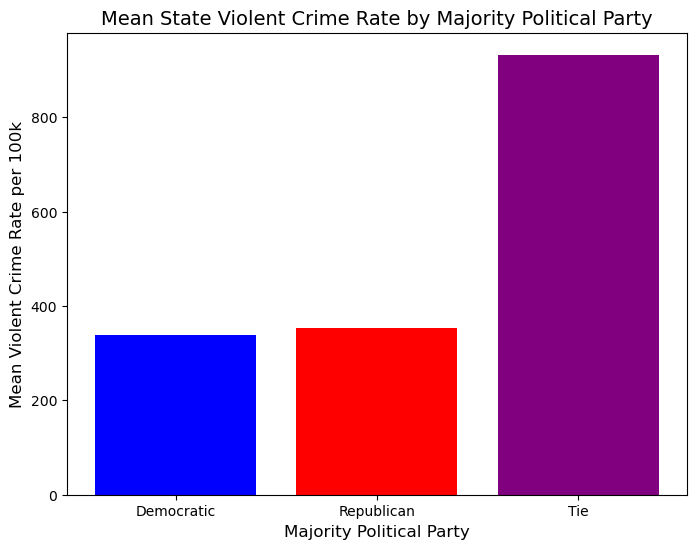

In [36]:
# Create a bar graph to visualize mean violent crime by political party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load summary statistics table into a pandas DataFrame
summary_table = r"C:\Users\viver\OneDrive\Desktop\crime_analysis\crime_analysis.gdb\USA_States_Crime_Statistics"
fields = ["USA_States_Political_Join_state_majority_party_csv_Majority_Part", "MEAN_Violent_crime_and_solved_crime_by_state__2024___Sheet1_csv_"]
data = []
with arcpy.da.SearchCursor(summary_table, fields) as cursor:
    for row in cursor:
        data.append(row)
df = pd.DataFrame(data, columns=["Political_Party", "Mean_Violent_Crime"])

# Create bar graph
plt.figure(figsize=(8, 6))
plt.bar(df["Political_Party"], df["Mean_Violent_Crime"], color=['blue', 'red', 'purple'])
plt.xlabel("Majority Political Party", fontsize=12)
plt.ylabel("Mean Violent Crime Rate per 100k", fontsize=12)
plt.title("Mean State Violent Crime Rate by Majority Political Party", fontsize=14)

# Export graph as an image file
plt.savefig(r"..\figures\mean_violent_crime_by_party.jpg", dpi=300)

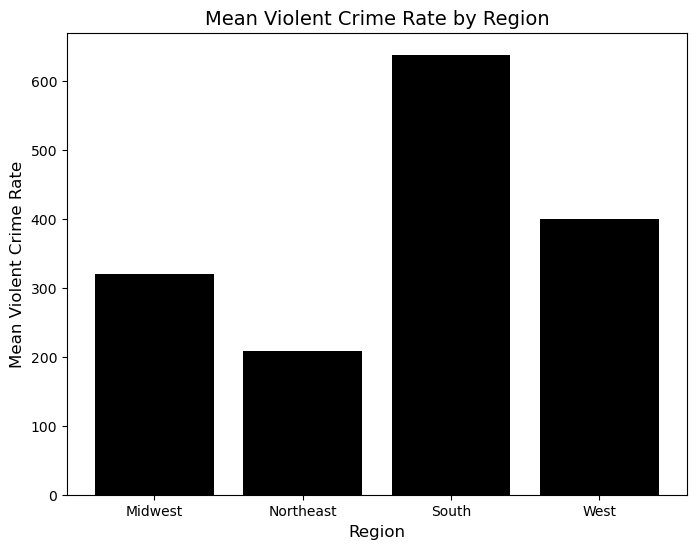

In [ ]:
# Create a bar graph to visualize mean violent crime by region
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load summary statistics table into a pandas DataFrame
summary_table = r"C:\Users\viver\OneDrive\Desktop\crime_analysis\crime_analysis.gdb\USA_States_Region_Statistics"
fields = ["USA_States_Political_Join_USA_States_Region", "MEAN_Violent_crime_and_solved_crime_by_state__2024___Sheet1_csv_"]
data = []
with arcpy.da.SearchCursor(summary_table, fields) as cursor:
    for row in cursor:
        data.append(row)
df = pd.DataFrame(data, columns=["Region", "Mean_Violent_Crime"])

# Create bar graph
plt.figure(figsize=(8, 6))
plt.bar(df["Region"], df["Mean_Violent_Crime"], color='black')
plt.xlabel("Region", fontsize=12)
plt.ylabel("Mean Violent Crime Rate per 100k", fontsize=12)
plt.title("Mean Violent Crime Rate by Region", fontsize=14)

# Export graph as an image file
plt.savefig(r"..\figures\mean_violent_crime_by_region.jpg", dpi=300)

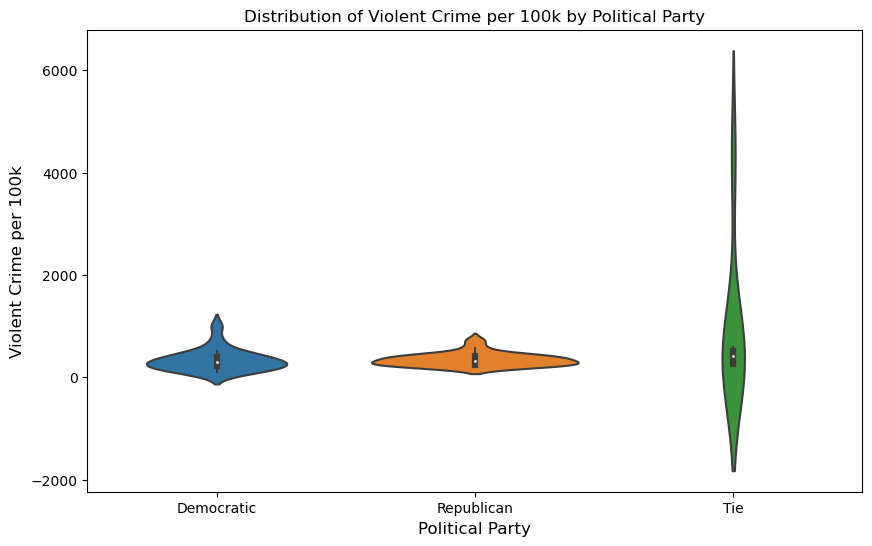

In [ ]:
# Create violin plot to visualize distribution of violent crime by political party
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Load summary statistics table into a pandas DataFrame
crime_statistics_table = r"C:\Users\viver\OneDrive\Desktop\crime_analysis\crime_analysis.gdb\USA_Crime_Table"
df = pd.DataFrame(arcpy.da.TableToNumPyArray(crime_statistics_table, ["USA_States_Political_Join_state_majority_party_csv_Majority_Part", "Violent_crime_and_solved_crime_by_state__2024___Sheet1_csv_Viole"]))

# Create violin plot    
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x="USA_States_Political_Join_state_majority_party_csv_Majority_Part", y="Violent_crime_and_solved_crime_by_state__2024___Sheet1_csv_Viole", data=df)
ax.set_xlabel("Political Party", fontsize=12)
ax.set_ylabel("Violent Crime per 100k", fontsize=12)
plt.title("Distribution of Violent Crime per 100k by Political Party")

In [ ]:
# Add fields for percent change direction and absolute percent change
in_table = r"C:\Users\viver\OneDrive\Desktop\crime_analysis\crime_analysis.gdb\USA_States_Crime_Join"
arcpy.management.AddField(in_table, "Direction", "TEXT")
arcpy.management.AddField(in_table, "Abs_change", "DOUBLE")
arcpy.management.AddField(in_table, "Rotation", "DOUBLE")

# Calculate absolute change fields based on percent change in violent crime
arcpy.management.CalculateField(
    in_table=in_table,
    field="Abs_change",
    expression="abs(!Percent_Change_Violent_Crime!)",
    expression_type="PYTHON3",
    code_block="",
    field_type="DOUBLE",
    enforce_domains="NO_ENFORCE_DOMAINS"
)

# Calculate direction fields based on percent change in violent crime
arcpy.management.CalculateField(
    in_table="USA_Crime_Join",
    field="Direction",
    expression="direction_change(!Percent_Change_Violent_Crime!, !Direction!)",
    expression_type="PYTHON3",
    code_block="""def direction_change(infield, outfield):
    if infield > 0:
        outfield = 'Increase'
    else:
        outfield = 'Decrease'
            
    return outfield
        """,
    field_type="TEXT",
    enforce_domains="NO_ENFORCE_DOMAINS"
)

# Calculate rotation fields based on direction of percent change in violent crime
arcpy.management.CalculateField(
    in_table="USA_Crime_Join_FeatureToPoint",
    field="Rotation",
    expression="rotate(!Direction!, !Rotation!)",
    expression_type="PYTHON3",
    code_block="""def rotate(in_field, update_field):
    if in_field == 'Increase':
        update_field = 0
    else:
        update_field = 180
    return update_field""",
    field_type="TEXT",
    enforce_domains="NO_ENFORCE_DOMAINS"
)

In [ ]:
# Convert joined feature class to point feature class for better visualization in ArcGIS Pro
arcpy.management.FeatureToPoint(
    in_features="USA_Crime_Join",
    out_feature_class=r"C:\Users\viver\OneDrive\Desktop\crime_analysis\crime_analysis.gdb\USA_Crime_Join_FeatureToPoin",
    point_location="CENTROID"
)